Let’s first load all the necessary libraries:

In [3]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
!python -m pip install -U gensim


Requirement already up-to-date: gensim in c:\users\admin\anaconda3\lib\site-packages (4.0.1)


In [5]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
#import pyLDAvis.gensim
#from pyLDAvis import gensim
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\admin\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [32]:
df = pd.read_csv('Testdata.csv', encoding='utf-8')
df

,Unnamed: 0,text,sentiment
0,0,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!,5
1,1,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv,5
2,2,"If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?",2
3,3,Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.,2
4,4,Just saw Google self-driving car on I-34. It was painted green and blue.,3
...,...,...,...
6938,7141,Florida is one of a few states that allows testing of autonomous vehicles #sayfie,3
6939,7142,Many states still considering allowing self-driving car testing,3
6940,7143,Heading to a tech conference which will focus on transportation and driverless cars #AV #Innovation,3
6941,7144,Fully autonomous vehicles are one of many automation technologies,3


As you can see, the data contains the following columns:
    * text- Tweets
    * class

we will be using only the text column, i.e., text.

## Data Preprocessing
Data preprocessing and cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data.

In [33]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 30 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

Let’s try this function and find out which are the most common words in our reviews dataset.

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


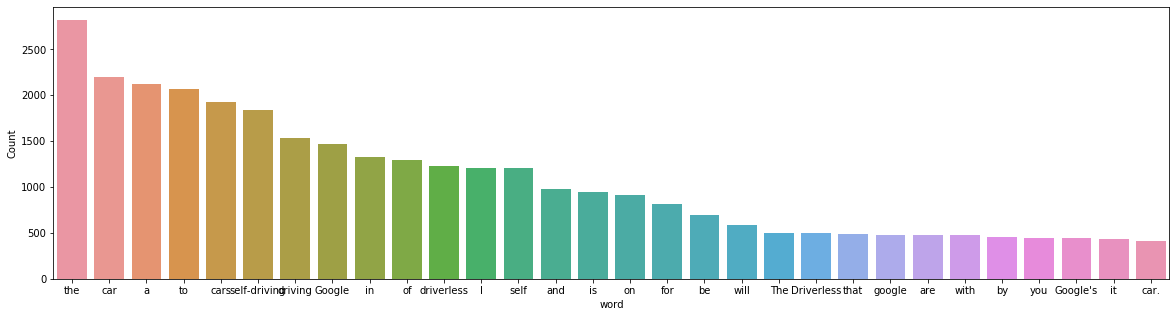

In [34]:
freq_words(df['text'])

Most common words are ‘the’, ‘and’, ‘to’, so on and so forth. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Before that let’s remove the punctuations and numbers from our text data.

In [35]:
# remove unwanted characters, numbers and symbols
df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Let’s try to remove the stopwords and short words (<5 letters) from the reviews.

In [36]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [37]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 5)
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>5]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['text']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

Let’s again plot the most frequent 40 words and see if the more significant words have come out.

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


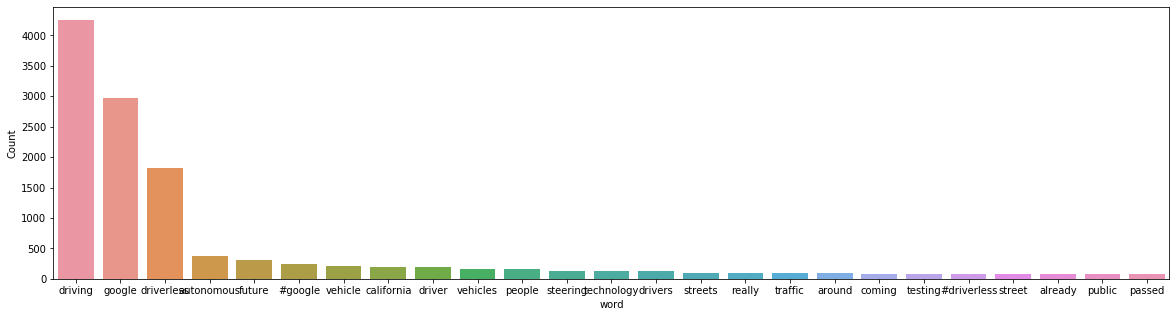

In [38]:
freq_words(reviews, 25)

We can see some improvement here. Terms like ‘driving’, ‘self’, ‘car’, ‘saw’ have come up which are quite relevant for the car category. However, we still have neutral terms like ‘just’, ‘could’, ‘get’, ‘one’ which are not that relevant.

To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.

In [39]:
#!python -m spacy download en # one time run
#import spacy spacy.load('en_core_web_sm')
nlp = spacy.load("en_core_web_sm")


In [14]:
!python -m spacy download en 



[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [40]:
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm")
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output


Let’s tokenize the reviews and then lemmatize the tokenized reviews.

In [41]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['awesome', 'google', 'driverless', 'travel']


In [42]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['awesome', 'google', 'driverless', 'travel']


As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized reviews and plot the most common words.

C:\Users\admin\anaconda3\lib\site-packages\seaborn\categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


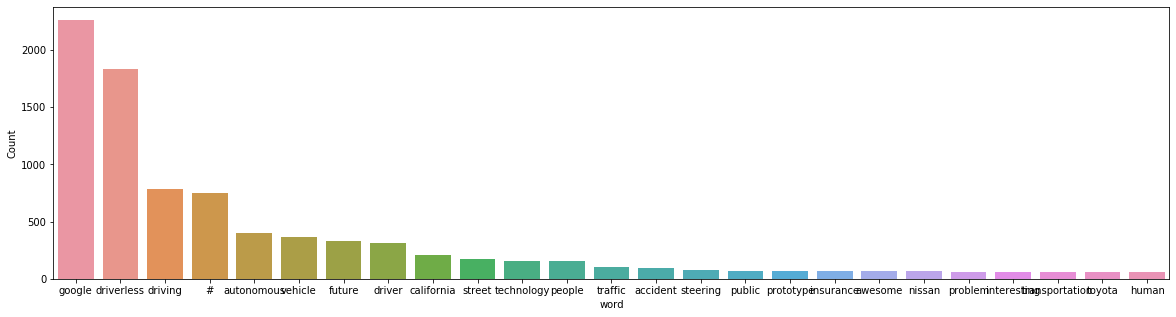

In [43]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 25)

it seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.

## Building an LDA model

We will start by creating the term dictionary of our corpus, where every unique term is assigned an index

In [44]:
dictionary = corpora.Dictionary(reviews_2)

Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.

In [45]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [46]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

the code above will take a while. Please note that I have specified the number of topics as 10 for this model using the num_topics parameter. You can specify any number of topics using the same parameter.

Let’s print out the topics that our LDA model has learned.

In [47]:
lda_model.print_topics()

[(0,
  '0.251*"driving" + 0.014*"service" + 0.014*"business" + 0.013*"amazing" + 0.012*"parking" + 0.010*"breakthrough" + 0.009*"transit" + 0.009*"system" + 0.008*"truck" + 0.007*"automaker"'),
 (1,
  '0.168*"driverless" + 0.022*"problem" + 0.019*"transportation" + 0.016*"change" + 0.013*"computer" + 0.011*"enough" + 0.008*"city" + 0.008*"impact" + 0.008*"ownership" + 0.007*"automobile"'),
 (2,
  '0.101*"#" + 0.099*"autonomous" + 0.094*"vehicle" + 0.045*"people" + 0.017*"nissan" + 0.012*"safety" + 0.012*"toyota" + 0.009*"ticket" + 0.009*"research" + 0.008*"codecon"'),
 (3,
  '0.088*"driver" + 0.086*"google" + 0.039*"driverless" + 0.024*"steering" + 0.023*"accident" + 0.023*"prototype" + 0.017*"unveil" + 0.015*"innovation" + 0.015*"valley" + 0.013*"silicon"'),
 (4,
  '0.026*"drone" + 0.022*"driverless" + 0.019*"available" + 0.018*"well" + 0.017*"thank" + 0.015*"wonder" + 0.014*"control" + 0.013*"amazon" + 0.010*"museum" + 0.008*"working"'),
 (5,
  '0.290*"google" + 0.049*"driverless" + 

The fourth topic Topic 3 has terms like ‘towel’, ‘clean’, ‘wax’, ‘water’, indicating that the topic is very much related to car-wash. Similarly, Topic 6 seems to be about the overall value of the product as it has terms like ‘price’, ‘quality’, and ‘worth’.

 

## topics Visualization

To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [48]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.224948 -0.077510       1        1  19.396222
2     -0.105793 -0.307208       2        1  11.848301
7      0.005578 -0.007665       3        1  11.542130
8      0.149981  0.062367       4        1  10.703883
0     -0.208953  0.125498       5        1  10.653545
1      0.029675  0.089698       6        1  10.331747
3      0.143283  0.036022       7        1   9.944191
6     -0.107153  0.023074       8        1   5.736203
4     -0.052936  0.034178       9        1   5.141018
9     -0.078630  0.021546      10        1   4.702761, topic_info=            Term         Freq        Total Category  logprob  loglift
4         google  1762.000000  1762.000000  Default  30.0000  30.0000
12       driving   654.000000   654.000000  Default  29.0000  29.0000
3     driverless  1120.000000  1120.000000  Default  28.0000  28.0000
7     autonomous   288.000000   288.000000  Default  27.0000  27.0000
18             #   568.000000   568.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
6323    legality     3.421532     4.138862  Topic10  -5.8177   2.8667
6325    overcome     3.421532     4.138862  Topic10  -5.8177   2.8667
5668     soylent     3.204355     3.921697  Topic10  -5.8833   2.8550
14        driver    20.873127   236.245670  Topic10  -4.0094   0.6306
490      testing     6.424868    44.645675  Topic10  -5.1876   1.1184

[375 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
18        1  0.367377          #
18        2  0.516788          #
18        3  0.116014          #
4136      2  0.841112     aarpca
147       3  0.245367   accident
...     ...       ...        ...
660       9  0.979002     wonder
746       9  0.942798    working
1022      7  0.978661  yesterday
1807      6  0.957651    youtube
2225      2  0.921441     zipcar

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 9, 1, 2, 4, 7, 5, 10])